In [1]:
## from warmup_scheduler import GradualWarmupScheduler


import os
import gc                                                                                                                                               
import copy
import yaml
import random
import shutil
import typing as tp
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, precision_recall_fscore_support
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch
from torch import nn
from torch import optim
from torch.optim import lr_scheduler
from torch.cuda import amp
import albumentations as A
# from sklearn.model_selection import StratifiedKFold
import albumentations
# import segmentation_models_pytorch as smp
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2
import time
from pylab import rcParams
rcParams['figure.figsize'] = 20,10
import warnings
warnings.simplefilter('ignore')
import gc
gc.enable()

# Imports
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
# from torchsummary import summary
import torchvision
import torch.optim as optim
from torch.autograd import Variable
from time import time
import torchvision.transforms as T
import torch.utils.data
# from natsort import natsorted
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import matplotlib.patches as mpatches
from matplotlib import patches
import time
from tqdm.notebook import tqdm
# import stainNorm_Macenko
# import stain_utils as utils
from sklearn.metrics import f1_score as f1_score_skf
import numpy as np



base_path = "../inference/data/"
IMG_SIZE_GLOBAL=512
IMG_SIZE_GLOBAL_VALID = 512

In [2]:
def set_seed(seed = 0):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random_state = np.random.RandomState(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    return random_state


RANDAM_SEED = 42
random_state = set_seed(RANDAM_SEED)

In [3]:
# !pip install torchstain
import torchstain
torch_normalizer = torchstain.normalizers.MacenkoNormalizer(backend='numpy')
image = cv2.imread('/home/salman/Downloads/Bilal/lowcost patho/lowcost_data/images/Case 13/IMG_6185.JPG')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image,(512,512))
torch_normalizer.fit(image)

In [4]:

class MitosisDataset(object):
    def __init__(self, images, masks, boxes, b_masks, transforms=None): # transforms
        
        self.imgs = images
        self.masks = masks
        self.boxes = boxes
        self.b_masks = b_masks
        self.transforms = transforms
    
    def __getitem__(self, idx):

        # img = utils.read_image(self.imgs[idx])
#         img = stain.transform(img)
        
        # img = np.array(Image.open(self.imgs[idx]).convert("RGB"))
        mask = np.array(Image.open(self.masks[idx]))
    

        img = cv2.imread(self.imgs[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img, H, E = torch_normalizer.normalize(I=img, stains=True)
        
        if self.transforms:
            tr = self.transforms(image = img, mask=mask)
            img = tr["image"]
            mask = tr["mask"]
        
        
        
        masks = []
        labels_add = []
            
            
        
#         
        count = 1
        instance_count = 0
        X,Y,W,H =0,0,0,0
        rois = []
        contours, hierarchy = cv2.findContours(np.array(mask),cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)[-2:]

        for cnt in contours:
            
            current_mask = np.zeros((mask.shape[0], mask.shape[1]))
            x,y,w,h = cv2.boundingRect(cnt)
            if w >1 and h>1:
        
                if count == 1:
                    count = 1
                    instance_count+=1
                    X, Y, W, H = x, y, w, h
                        
#                     if h<50 or w<50:
#                         current_mask[y:y+h, x:x+w] =0
#                         masks.append(current_mask)
#                         rois.append([X,Y, X+W, Y+H])
#                         labels_add.append(0)
                    if 1==1:
                        current_mask[y:y+h, x:x+w] =1
                        masks.append(current_mask)
                        rois.append([X,Y, X+W, Y+H])
                        labels_add.append(1)
                   
                    x, y, w, h = 0, 0, 0, 0
                    
                    
            

                count=1
        img = img / 255.0
        img = np.transpose(img, (2, 0, 1))
        
        boxes = np.array(rois)
        labels = torch.as_tensor(np.array(labels_add), dtype=torch.int64)

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
            

        target = {}
        boxes.unsqueeze(0)
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["path"] = self.imgs[idx]
        
        print(boxes)

        return torch.tensor(img), target

    def __len__(self):
#         return 16
        return len(self.imgs)

In [5]:
add_path = base_path + "skmh_T-138a"
def change_path(file):
    return add_path + file

test_df= pd.read_csv(os.path.join(base_path, "skmh_T-138a", "shoukat_khanam_additional.csv" ))
# test_df = test_df.iloc[0:100].reset_index(drop=True)
print(test_df)



test_df["file"] = test_df["file"].apply(change_path).reset_index(drop=True) 
test_df["mask"] = test_df["mask"].apply(change_path).reset_index(drop=True)

# print(test_df)

                          file                     mask
0      /positive_patches/0.png    /positive_masks/0.png
1      /positive_patches/1.png    /positive_masks/1.png
2      /positive_patches/2.png    /positive_masks/2.png
3      /positive_patches/3.png    /positive_masks/3.png
4      /positive_patches/4.png    /positive_masks/4.png
..                         ...                      ...
254  /positive_patches/254.png  /positive_masks/254.png
255  /positive_patches/255.png  /positive_masks/255.png
256  /positive_patches/256.png  /positive_masks/256.png
257  /positive_patches/257.png  /positive_masks/257.png
258  /positive_patches/258.png  /positive_masks/258.png

[259 rows x 2 columns]


In [6]:
# f, axarr =plt.subplots(30, 2,  figsize=(30, 300))
# for i in range(30):
#     img = cv2.imread(test_df["file"][i])
#     mask = cv2.imread(test_df["mask"][i])
#     mask = np.where(mask==1, 255, 0)
#     axarr[i,0].imshow(img)
#     axarr[i, 1].imshow(mask, cmap="gray")

In [7]:
import torchvision

transforms_valid = albumentations.Compose([
    albumentations.Resize(IMG_SIZE_GLOBAL_VALID, IMG_SIZE_GLOBAL_VALID)
])

dataset_test = MitosisDataset(test_df["file"], test_df["mask"],None, None, transforms=transforms_valid)
data_loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=12, pin_memory=True, num_workers=3,shuffle=False, collate_fn=lambda x:list(zip(*x)))

print(len(data_loader_test))



22


In [8]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [9]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


num_classes = 2
# load an instance segmentation model pre-trained pre-trained on COCO
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# now get the number of input features for the mask classifier
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer =128
# and replace the mask predictor with a new one
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                    hidden_layer,
                                                    num_classes)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.load_state_dict(torch.load(base_path + "microscopic_max.pth"))
model=model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0001, momentum=0.9, weight_decay=0.05)


In [10]:
def IoU(y_real, y_pred):
    intersection = y_real*y_pred
    union = (y_real+y_pred)-(y_real*y_pred)
    return np.sum(intersection)/np.sum(union)

def dice_coef(y_real, y_pred, smooth=0.01):
    intersection = y_real*y_pred
    union = (y_real+y_pred)-(y_real*y_pred)
    return np.mean((2*intersection+smooth)/(union+smooth))

def confusion_matrix(y_true, y_pred):
    y_true= y_true.flatten()
    y_pred = y_pred.flatten() * 2
    cm = y_true+y_pred
    cm = np.bincount(cm, minlength=4)
    tn, fn, fp, tp = cm
    return tn, fp, fn, tp

def get_f1_score(y_true, y_pred):
    """Return f1 score covering edge cases"""
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred)
    f1_score = (2 * tp) / ((2 * tp) + fp + fn)

    return f1_score 

def get_f1_score_detection(tp,fp,fn):
    """Return f1 score covering edge cases"""
    f1_score = (2 * tp) / ((2 * tp) + fp + fn)

    return f1_score 

In [11]:
import numpy as np
from torchvision.ops import nms


class ConfusionMatrix:
    def __init__(self, num_classes: int, IOU_THRESHOLD=0.0):
        self.matrix = np.zeros((num_classes + 1, num_classes + 1))
        self.num_classes = num_classes
        self.IOU_THRESHOLD = IOU_THRESHOLD

    def process_batch(self, detections, labels: np.ndarray):
        """
        Return intersection-over-union (Jaccard index) of boxes.
        Both sets of boxes are expected to be in (x1, y1, x2, y2) format.
        Arguments:
            detections (Array[N, 6]), x1, y1, x2, y2, conf, class
            labels (Array[M, 5]), class, x1, y1, x2, y2
        Returns:
            None, updates confusion matrix accordingly
        """
        
        ## Non Maximum Suppression
        if len(detections) > 0:
            indexes = nms(boxes = detections, scores = torch.ones(len(detections), dtype=torch.float64), iou_threshold=0.5)
            detections = detections[indexes].numpy()
        
#         print(detections)

        tp = 0

        if len(labels) > 0 and len(detections) > 0:
            all_ious =torchvision.ops.box_iou(torch.tensor(detections), torch.tensor(labels))
            tp = np.sum(np.where(all_ious >= self.IOU_THRESHOLD,1,0))
            
#             if len(detections) >= len(labels):
            fp =0 
            fn  = 0
            fp = len(detections) - tp
            fn = len(labels) - tp
            
        elif len(labels)==0 and len(detections)==0:
            tp = 0
            fp = 0
            fn=0
            
        else:
            tp=0
            if len(detections) >= len(labels):
                fp = len(detections)
                fn=0
            else:
                fn = len(labels)
                fp=0
        
        return tp, fp, fn, 0


In [12]:
from math import ceil
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib import pyplot as plt

def show_images_from_list(images, one_row_size = 3):
    # images = [Image.fromarray(image) for image in images]
    rows, cols = ceil(len(images)/one_row_size), one_row_size
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize = (10, 300))
    
    for i, image in enumerate(images):
        plt.subplot(rows, cols, i+1)
        plt.imshow(image)

    
    plt.show()

In [13]:
 from sklearn.metrics import jaccard_score

In [14]:
#### Training 

In [15]:
# Perform training loop for n epochs
loss_list = []
n_epochs = 1
val_iou_list = []
test_iou_list=[]
max_pos=0.1
CONFIDENCE_THRESHOLD = 0.5

display_images = []
jaccard_scores = []

tp_all, tp_all_1 = 0, 0
fp_all, fp_all_1 =0, 0 
fn_all, fn_all_1 =0, 0

Threshold = 3000

model.eval()
conf_mat = ConfusionMatrix(num_classes = 1, IOU_THRESHOLD = 0.5)
conf_mat_1 = ConfusionMatrix(num_classes = 1, IOU_THRESHOLD = 0.3)
with torch.no_grad():
            
    # Get IoU score for whole test set
    f1_scores_only_pos = []
    f1_scores_list = []
    f1_scores_detection_list = []
    f1_scores_detection_list1 = []
    f1_score_sk = []
    f1_score_sk_updated = []
    f1_score_sk_micro = []
    f1_score_sk_macro = []
    affected_images = []
    dice_scores = []
    mitotic_count_score = 0
    skipped = 0
            
    for images,targets in tqdm(data_loader_test):
        total_len = len(images)
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) if k!="path" else v for k, v in t.items() } for t in targets]

        model=model.double()
        model.eval()
        output = model(images)
        images = list(image.cpu().detach().numpy() for image in images)
        for i in range(total_len):
            # print(targets)

            target_im = np.zeros((IMG_SIZE_GLOBAL_VALID, IMG_SIZE_GLOBAL_VALID))
            for k in range(len(targets[i]['masks'])):
                target_im2 = targets[i]['masks'][k].cpu().detach().numpy()
                target_im2[target_im2>=0.5] = 1
                target_im2[target_im2<0.5] = 0
                if np.unique(target_im2, return_counts=True)[1][1] < Threshold:
                    continue
                target_im = target_im+target_im2

            target_boxes = []

            target_boxes_1 = targets[i]["boxes"].cpu().detach().numpy()

            for tbox in target_boxes_1:
                if (tbox[2]-tbox[0]) * (tbox[3]-tbox[1]) >=Threshold:
                    target_boxes.append(tbox)

            target_boxes = np.array(target_boxes)

            target_im[target_im>=0.5] = 1
            target_im[target_im<0.5] = 0
            target_im = target_im.astype('int64')


            ##Prediction Boxes Calculation
            output_boxes = []
            output_boxes_all = output[i]["boxes"].cpu().detach().numpy()
            for k in range(len(output[i]["boxes"])):
                if output[i]["scores"][k] >= CONFIDENCE_THRESHOLD:
                    if (output_boxes_all[k][2]-output_boxes_all[k][0]) * (output_boxes_all[k][3]-output_boxes_all[k][1]) >=Threshold:
                        output_boxes.append(output_boxes_all[k])
            output_boxes = torch.tensor(output_boxes)


            tp, fp, fn, mt_count = conf_mat.process_batch(output_boxes, target_boxes)
            tp1, fp1, fn1, mt_count1 = conf_mat_1.process_batch(output_boxes, target_boxes)
#                   
            tp_all+=tp 
            tp_all_1 +=tp1
            fp_all += fp
            fp_all_1 +=fp1
            fn_all+=fn 
            fn_all_1 +=fn1


            ## Prediction Masks Calculation
            if len (output[i]['masks']) < 1:
                output_im = np.zeros((IMG_SIZE_GLOBAL, IMG_SIZE_GLOBAL))
                skipped+=1
                affected_images.append(targets[i]["path"])
#                     continue
            else:
                output_im = np.zeros((IMG_SIZE_GLOBAL_VALID, IMG_SIZE_GLOBAL_VALID))

                for k in range(len(output[i]['masks'])):
                    if output[i]["scores"][k] < CONFIDENCE_THRESHOLD:
                        continue

                    output_im2 = output[i]['masks'][k][0,:,:].cpu().detach().numpy()
                    output_im2[output_im2>0.5] = 1
                    output_im2[output_im2<0.5] = 0
                    if np.unique(output_im2, return_counts=True)[1][1] < Threshold:
                        continue
                    output_im = output_im+output_im2

            output_im[output_im>0.5] = 1
            output_im[output_im<0.5] = 0
            output_im = output_im.astype('int64')



            y_true=target_im
            y_pred = output_im
            y_pred = y_pred > 0.5
            y_pred = y_pred.reshape(-1)
            y_pred = y_pred.astype(np.uint8)

            y_true = y_true > 0.5
            y_true = y_true.reshape(-1)
            y_true = y_true.astype(np.uint8)

            if len(np.unique(y_true)) <=1 and len(np.unique(y_pred)) <=1: #Empty Score Condition
                print('Here')
                continue




#             score_sk = f1_score_skf(y_true, y_pred, average='binary')
#             f1_score_sk.append(score_sk)    
#             score_sk = f1_score_skf(y_true, y_pred, average='micro')
#             f1_score_sk_micro.append(score_sk)
#             score_sk = f1_score_skf(y_true, y_pred, average='macro')
#             f1_score_sk_macro.append(score_sk)



            
#             import matplotlib.pyplot as plt
#             f, plot = plt.subplots(1,2)
#             plot[0].imshow(target_im)
#             plot[1].imshow(output_im)
            
            display_images.append(np.transpose(images[i],(1,2,0)))
            display_images.append(target_im)
            display_images.append(output_im)
                

   
    print('mean f1 score for test set:', np.mean(f1_scores_list))
    print('mean f1 score detection for test set:', get_f1_score_detection(tp_all, fp_all, fn_all))
    print('mean f1 score detection1 for test set:', get_f1_score_detection(tp_all_1, fp_all_1, fn_all_1))
#     print('mean f1 score (binary):', np.mean(f1_score_sk))

#     print('mean f1 score (micro):', np.mean(f1_score_sk_micro))
#     print('mean f1 score (macro):', np.mean(f1_score_sk_macro))
#     print('mean f1 score (only positives):', np.mean(f1_scores_only_pos))


    print(tp_all, fp_all, fn_all)
    print(tp_all_1, fp_all_1, fn_all_1)
    
    

    print(skipped)
    
   

        
                                                                    



  0%|          | 0/22 [00:00<?, ?it/s]

tensor([[296., 104., 394., 202.]])
tensor([[150., 158., 210., 218.]])
tensor([[422.,  82., 490., 150.]])
tensor([[  8., 196., 116., 304.]])
tensor([[ 90., 258., 148., 316.]])
tensor([[304., 224., 424., 344.]])
tensor([[230.,  44., 294., 108.]])
tensor([[378.,  36., 438.,  96.]])
tensor([[320.,   0., 418.,  98.]])
tensor([[ 90., 320., 162., 392.]])
tensor([[250., 382., 334., 466.]])
tensor([[ 82.,   0., 164.,  82.]])
tensor([[302., 134., 356., 188.]])
tensor([[202., 234., 264., 296.]])
tensor([[252., 112., 318., 178.]])
tensor([[ 12.,  78.,  96., 162.]])
tensor([[384., 144., 442., 202.]])
tensor([[112., 138., 176., 202.]])
tensor([[234., 214., 320., 300.]])
tensor([[230., 200., 280., 250.]])
tensor([[294., 444., 346., 496.]])
tensor([[434.,  70., 506., 142.]])
tensor([[134., 392., 208., 466.]])tensor([[340., 164., 400., 224.]])

tensor([[160., 184., 244., 268.]])
tensor([[232., 296., 288., 352.]])
tensor([[ 44., 112., 110., 178.]])
tensor([[156., 404., 214., 462.]])
tensor([[434., 258.,

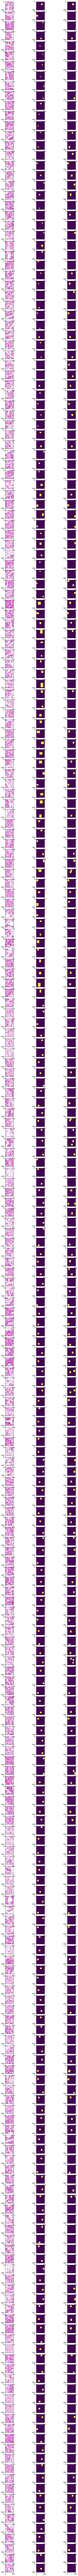

In [16]:
show_images_from_list(display_images, one_row_size=3)

In [17]:
# # print(val_iou_list)
# # print(test_iou_list)
# model_nr = 3
# save_path = base_path + 'microscopic_'+str(model_nr) +".pth"
# torch.save(model.state_dict(), save_path)

In [18]:
precision = tp_all / (tp_all + fp_all)
recall = tp_all/(tp_all + fn_all)
print("Precision:", precision )
print("Recall: ", recall)

Precision: 0.22535211267605634
Recall:  0.12648221343873517


In [19]:

precision = tp_all_1 / (tp_all_1 + fp_all_1)
recall = tp_all_1/(tp_all_1 + fn_all_1)
print("Precision:", precision )
print("Recall: ", recall)

Precision: 0.5563380281690141
Recall:  0.31225296442687744


: 

: 

: 